<a href="https://colab.research.google.com/github/wirungu/deep-learning-finance/blob/main/Deep_Learning_in_Financial_Time_Series_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

I recently ran across this [implementation](https://towardsdatascience.com/predicting-stock-prices-using-a-keras-lstm-model-4225457f0233)  of an LSTM network for stock price prediction, which seemed to me to have some mistakes. (Exercise: What's the main thing wrong with the forecasting?)

I was still curious how effective a crude RNN time series model could be, and particularly whether even the naive benchmark could be beaten given that certain strong forms of the EMH would seem to forbid this: shouldn't today's price be in some sense the best possible indicator for tomorrow's price? Do standard deep learning approaches match or exceed cutting-edge *classical* time series techniques on financial data?
This is my attempt at finding out, and an excuse to learn more about deep learning, time series forecasting and finance.

I've tried to indicate it whenever I actively choose between different possible approaches, and to document anything I'm unsure about in hopes that someone wiser will gently steer me towards a better approach.

# Modules and data preprocessing

## Installation

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import yfinance as yf

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, MeanSquaredLogarithmicError, RootMeanSquaredError
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

Instead of messing with CSVs we'll just use the [Yahoo! Finance API yfinance](https://pypi.org/project/yfinance/) . We'll analyze `MSFT` as a warmup since that's the ticker in the example code there. Yahoo! Finance allows me to access 60 days worth of data at a 5 minute granularity, 7 days of 1 minute data, 2 years of hourly data and daily data going back over 10 years. For now we're analyzing 2 years of data, but I may need to change this or seek more and better data from elsewhere.


In [2]:
df = yf.download("MSFT", period= "730d", interval="1h")
# Let's take a look at the data
df.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Datetime,,,,,,
2020-08-26 09:30:00-04:00,218.649994,219.649994,217.360001,219.389999,219.389999,7197222
2020-08-26 10:30:00-04:00,219.389999,221.149994,219.300003,221.070007,221.070007,5006187
2020-08-26 11:30:00-04:00,221.059998,222.089996,220.990005,221.615005,221.615005,3926649
2020-08-26 12:30:00-04:00,221.619995,221.720001,219.550003,219.880005,219.880005,3893983
2020-08-26 13:30:00-04:00,219.889999,220.850006,219.539993,220.850006,220.850006,4121930


Some quick graphs:

<Axes: xlabel='Datetime'>

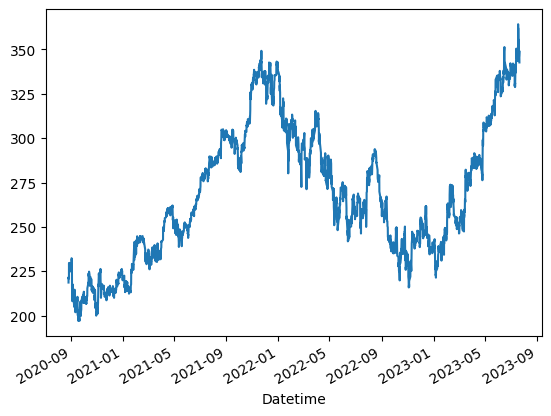

In [3]:
df['Open'].plot()

<Axes: xlabel='Datetime'>

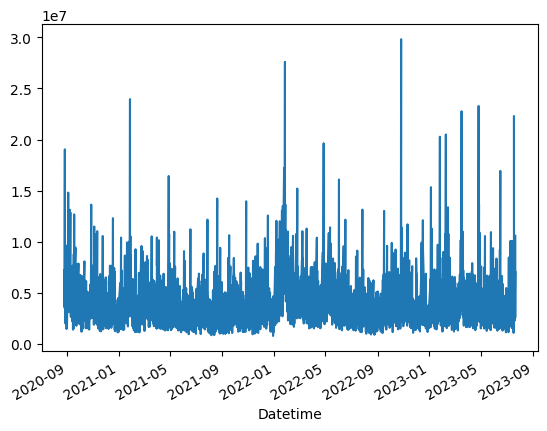

In [4]:
df['Volume'].plot()

Looks good!

We are going to attempt to forecast opening prices, so let's throw away everything else (for now).

In [5]:
df = df[['Open']]
df

,Open
Datetime,
2020-08-26 09:30:00-04:00,218.649994
2020-08-26 10:30:00-04:00,219.389999
2020-08-26 11:30:00-04:00,221.059998
2020-08-26 12:30:00-04:00,221.619995
2020-08-26 13:30:00-04:00,219.889999
...,...
2023-07-21 11:30:00-04:00,347.179993
2023-07-21 12:30:00-04:00,345.040009
2023-07-21 13:30:00-04:00,346.260010


## Data splitting
I've gone with a crude train-test-split for now. We may do a k-fold cross validation in a later attempt.

In [6]:
X = df.values
X_train_val, X_test = train_test_split(X, test_size=0.1, shuffle=False)
X_train, X_val = train_test_split(X_train_val, test_size=0.2, shuffle=False)

## Normalization

I nearly tore all my hair out on this. There are several available approaches, each with its drawbacks: min-max scaling can't know the minimum or maximum of out-of sample data and that seems particularly ill suited for compounding processes like stock prices. z-score normalization is probably going to work OK, but financial data is famously [heteroskedastic](https://corporatefinanceinstitute.com/resources/data-science/heteroskedasticity/), so you would expect this to fall apart eventually.

I wasn't able to find decisive advice on suitably robust normalization: the most direct resource I found was the paper [*Impact of Data Normalization on Stock Index Forecasting*](https://www.mirlabs.org/ijcisim/regular_papers_2014/IJCISIM_24.pdf)
by Nayak et al. (and [this](https://arxiv.org/pdf/1812.05519) very similar paper by a different author.)

They essentially suggested a sigmoid normalization $\hat{x} = \frac{1}{1+e^x}.$
I suppose we'll have to experiment and find out

I have for now decided to just use `tf.keras.layers.Normalization`.

I've also not seen any such models use logarithmic returns instead of raw prices, and I do not fully understand why this is the case. Seems to me that's exactly the missing information a machine learning model needs to supply if it's going to be worth anything. Do your log returns predictions beat a random walk? If not, go home.

For now, we bow to precedent.

In [7]:
# Normalization
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(X_train)

norm_X_train = normalizer(X_train)
norm_X_val = normalizer(X_val)
norm_X_test = normalizer(X_test)

# Inverse Normalizer
inverse_normalizer = tf.keras.layers.Normalization(axis=-1, invert=True)
inverse_normalizer.adapt(X_train)

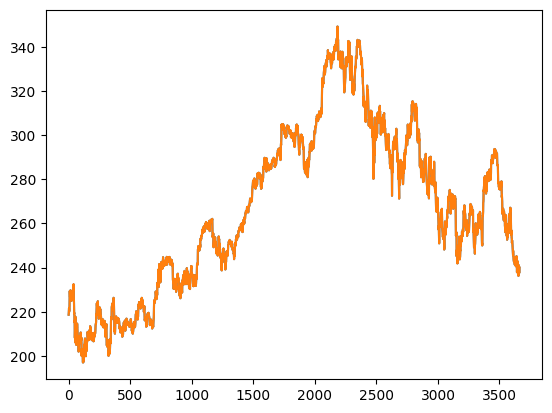

In [8]:
# Just checking;
plt.plot(inverse_normalizer(norm_X_train))
plt.plot(X_train)

Phew!


# Modeling



## Data windowing
I know `tf.keras.preprocessing.sequence.TimeseriesGenerator` is deprecated, but it's really easy to use, and `tf.data.Dataset` was a little too fiddly in my first try.

I've also gone with a sliding window rather than an expanding one. Not sure whether that's better. We'll think about this later, too.

In [9]:
# Windowing and batching
window_size = 60  # Size of the window
batch_size = 32  # Number of samples in each batch

# Create TimeseriesGenerator for training data
train_data_generator = TimeseriesGenerator(norm_X_train, norm_X_train, length=window_size, batch_size=batch_size)

# Create TimeseriesGenerator for validation data
val_data_generator = TimeseriesGenerator(norm_X_val, norm_X_val, length=window_size, batch_size=batch_size)

I'll probably end up switching to something like the code below:

In [10]:
# def windowing(vec, windowsize=60, batch_size=32):
#     dataset = tf.data.Dataset.from_tensor_slices(vec)
#     dataset = dataset.window(windowsize + 1, shift=1, drop_remainder=True)
#     dataset = dataset.flat_map(lambda window: window.batch(windowsize + 1))
#     dataset = dataset.map(lambda window: (window[:-1], window[-1]))
#     dataset = dataset.batch(batch_size)
#     return dataset

## Model training and validation

Let's build a model! I'm still researching what layers the final version should have, and what metrics to use, but here's a preliminary version, just to see what the results should look like.

In [11]:
# Model 1: First Model
model1 = Sequential()
model1.add(LSTM(64, input_shape=(60, 1)))
model1.add(Dense(8, activation='relu'))
model1.add(Dense(1))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 8)                 520       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


Let's create another model, with more LSTMs and a dropout layer:

In [12]:
# Model 2: Model with More LSTMs and Dropout
model2 = Sequential()
model2.add(LSTM(64, input_shape=(window_size, 1), return_sequences=True))
model2.add(LSTM(64, return_sequences=True))
model2.add(LSTM(64))
model2.add(Dropout(0.2))
model2.add(Dense(8, activation='relu'))
model2.add(Dense(1))

Compiling and fitting our models:

In [13]:
num_epochs = 50

# Compile and fit the models using the TimeseriesGenerator data
model1.compile(optimizer=Adam(), loss='mse', metrics=[MeanAbsoluteError(), MeanSquaredError(), MeanSquaredLogarithmicError(), RootMeanSquaredError()])
history1 = model1.fit(train_data_generator, epochs=num_epochs, validation_data=val_data_generator)

model2.compile(optimizer=Adam(), loss='mse', metrics=[MeanAbsoluteError(), MeanSquaredError(), MeanSquaredLogarithmicError(), RootMeanSquaredError()])
history2 = model2.fit(train_data_generator, epochs=num_epochs, validation_data=val_data_generator)

Epoch 1/50
113/113 [==============================] - 14s 84ms/step - loss: 0.0805 - mean_absolute_error: 0.1627 - mean_squared_error: 0.0805 - mean_squared_logarithmic_error: 0.0140 - root_mean_squared_error: 0.2837 - val_loss: 0.0102 - val_mean_absolute_error: 0.0785 - val_mean_squared_error: 0.0102 - val_mean_squared_logarithmic_error: 0.0011 - val_root_mean_squared_error: 0.1012
Epoch 2/50
113/113 [==============================] - 7s 64ms/step - loss: 0.0091 - mean_absolute_error: 0.0737 - mean_squared_error: 0.0091 - mean_squared_logarithmic_error: 0.0017 - root_mean_squared_error: 0.0953 - val_loss: 0.0096 - val_mean_absolute_error: 0.0763 - val_mean_squared_error: 0.0096 - val_mean_squared_logarithmic_error: 0.0011 - val_root_mean_squared_error: 0.0981
Epoch 3/50
113/113 [==============================] - 5s 40ms/step - loss: 0.0080 - mean_absolute_error: 0.0668 - mean_squared_error: 0.0080 - mean_squared_logarithmic_error: 0.0015 - root_mean_squared_error: 0.0895 - val_loss: 0

Let's see what the loss curves look like:

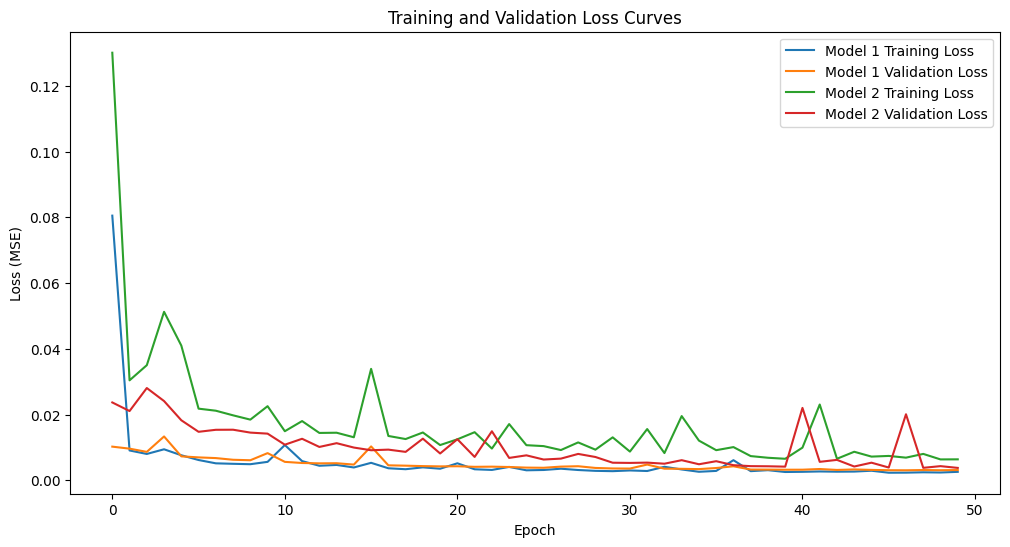

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(history1.history['loss'], label='Model 1 Training Loss')
plt.plot(history1.history['val_loss'], label='Model 1 Validation Loss')
plt.plot(history2.history['loss'], label='Model 2 Training Loss')
plt.plot(history2.history['val_loss'], label='Model 2 Validation Loss')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

# Testing

First let's predict on the validation set:

In [15]:
# Predict on validation data
val_predictions1 = model1.predict(val_data_generator)
val_predictions2 = model2.predict(val_data_generator)

# Inverse transform the normalized predictions and actual values
val_predictions1 = inverse_normalizer(val_predictions1)
val_predictions2 = inverse_normalizer(val_predictions2)
actual_vals = inverse_normalizer(norm_X_val[window_size:])

27/27 [==============================] - 2s 29ms/step


We'll also compute some statistics for our models:

In [16]:
# Calculate statistics for Model 1 on validation data
mae_model1_val = np.mean(np.abs(val_predictions1 - actual_vals))
mse_model1_val = np.mean((val_predictions1 - actual_vals)**2)
rmse_model1_val = np.sqrt(mse_model1_val)
residuals_model1_val = actual_vals - val_predictions1

# Calculate statistics for Model 2 on validation data
mae_model2_val = np.mean(np.abs(val_predictions2 - actual_vals))
mse_model2_val = np.mean((val_predictions2 - actual_vals)**2)
rmse_model2_val = np.sqrt(mse_model2_val)
residuals_model2_val = actual_vals - val_predictions2

Now some graphs:

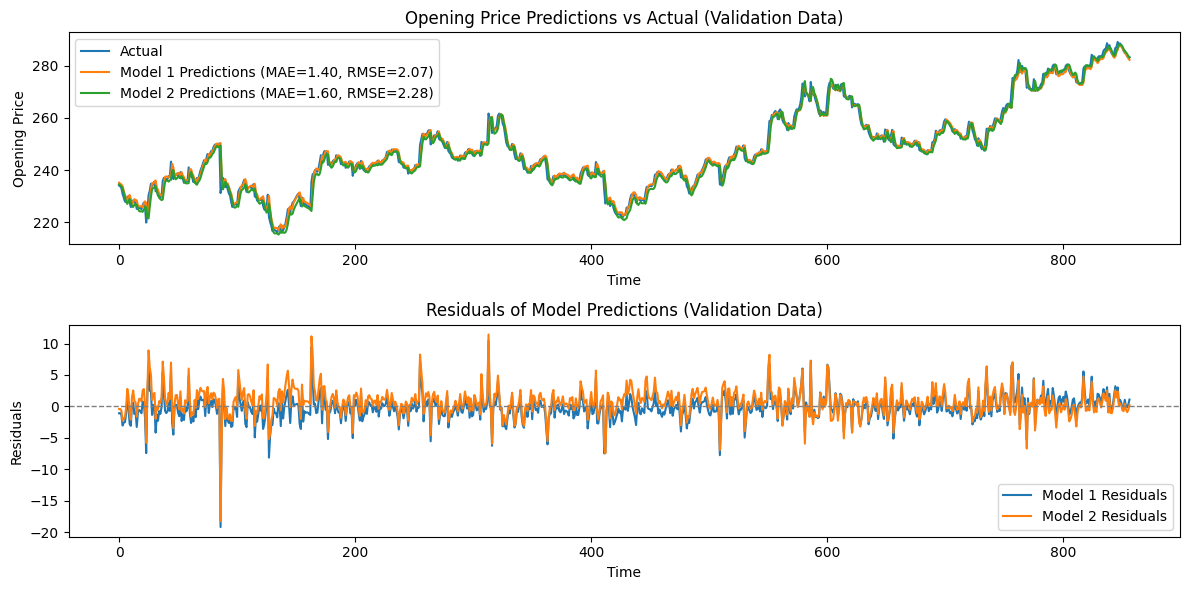

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(actual_vals, label='Actual')
plt.plot(val_predictions1, label=f'Model 1 Predictions (MAE={mae_model1_val:.2f}, RMSE={rmse_model1_val:.2f})')
plt.plot(val_predictions2, label=f'Model 2 Predictions (MAE={mae_model2_val:.2f}, RMSE={rmse_model2_val:.2f})')
plt.title('Opening Price Predictions vs Actual (Validation Data)')
plt.xlabel('Time')
plt.ylabel('Opening Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(residuals_model1_val, label='Model 1 Residuals')
plt.plot(residuals_model2_val, label='Model 2 Residuals')
plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.title('Residuals of Model Predictions (Validation Data)')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.tight_layout()
plt.show()

Now the moment of truth: we do the same for the test data:

In [18]:
test_data_generator = TimeseriesGenerator(norm_X_test, norm_X_test, length=window_size, batch_size=batch_size)

# Predict on test data
test_predictions1 = model1.predict(test_data_generator)
test_predictions2 = model2.predict(test_data_generator)

# Inverse transform the normalized predictions and actual values
test_predictions1 = inverse_normalizer(test_predictions1)
test_predictions2 = inverse_normalizer(test_predictions2)
actual_tests = inverse_normalizer(norm_X_test[window_size:])

# Calculate statistics for Model 1 on test data
mae_model1_test = np.mean(np.abs(test_predictions1 - actual_tests))
mse_model1_test = np.mean((test_predictions1 - actual_tests)**2)
rmse_model1_test = np.sqrt(mse_model1_test)
residuals_model1_test = actual_tests - test_predictions1

# Calculate statistics for Model 2 on test data
mae_model2_test = np.mean(np.abs(test_predictions2 - actual_tests))
mse_model2_test = np.mean((test_predictions2 - actual_tests)**2)
rmse_model2_test = np.sqrt(mse_model2_test)
residuals_model2_test = actual_tests - test_predictions2


15/15 [==============================] - 0s 27ms/step


Some plots for the training data:

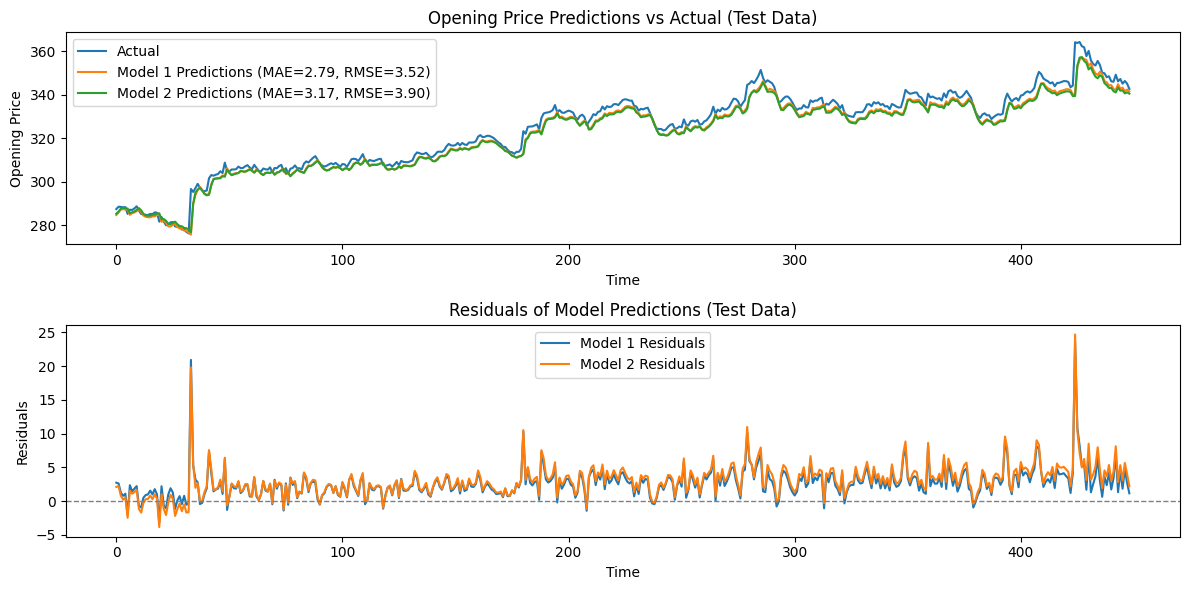

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(actual_tests, label='Actual')
plt.plot(test_predictions1, label=f'Model 1 Predictions (MAE={mae_model1_test:.2f}, RMSE={rmse_model1_test:.2f})')
plt.plot(test_predictions2, label=f'Model 2 Predictions (MAE={mae_model2_test:.2f}, RMSE={rmse_model2_test:.2f})')
plt.title('Opening Price Predictions vs Actual (Test Data)')
plt.xlabel('Time')
plt.ylabel('Opening Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(residuals_model1_test, label='Model 1 Residuals')
plt.plot(residuals_model2_test, label='Model 2 Residuals')
plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.title('Residuals of Model Predictions (Test Data)')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.tight_layout()
plt.show()

## Naive benchmark
Let's see how all this compares to the naive benchmark: using the last timestep as the next prediction.

In [20]:
# Implement the Naive Benchmark Model
naive_val_predictions = norm_X_val[window_size - 1:-1]
naive_test_predictions = norm_X_test[window_size - 1:-1]

# Inverse transform the normalized naive benchmark predictions and actual values
naive_val_predictions = inverse_normalizer(naive_val_predictions)
naive_test_predictions = inverse_normalizer(naive_test_predictions)

# Calculate statistics for the Naive Benchmark on validation data
mae_naive_val = np.mean(np.abs(naive_val_predictions - actual_vals))
mse_naive_val = np.mean((naive_val_predictions - actual_vals)**2)
rmse_naive_val = np.sqrt(mse_naive_val)
residuals_naive_val = actual_vals - naive_val_predictions

# Calculate statistics for the Naive Benchmark on test data
mae_naive_test = np.mean(np.abs(naive_test_predictions - actual_tests))
mse_naive_test = np.mean((naive_test_predictions - actual_tests)**2)
rmse_naive_test = np.sqrt(mse_naive_test)
residuals_naive_test = actual_tests - naive_test_predictions

Plotting predictions vs actual values and residuals for the naive benchmark:

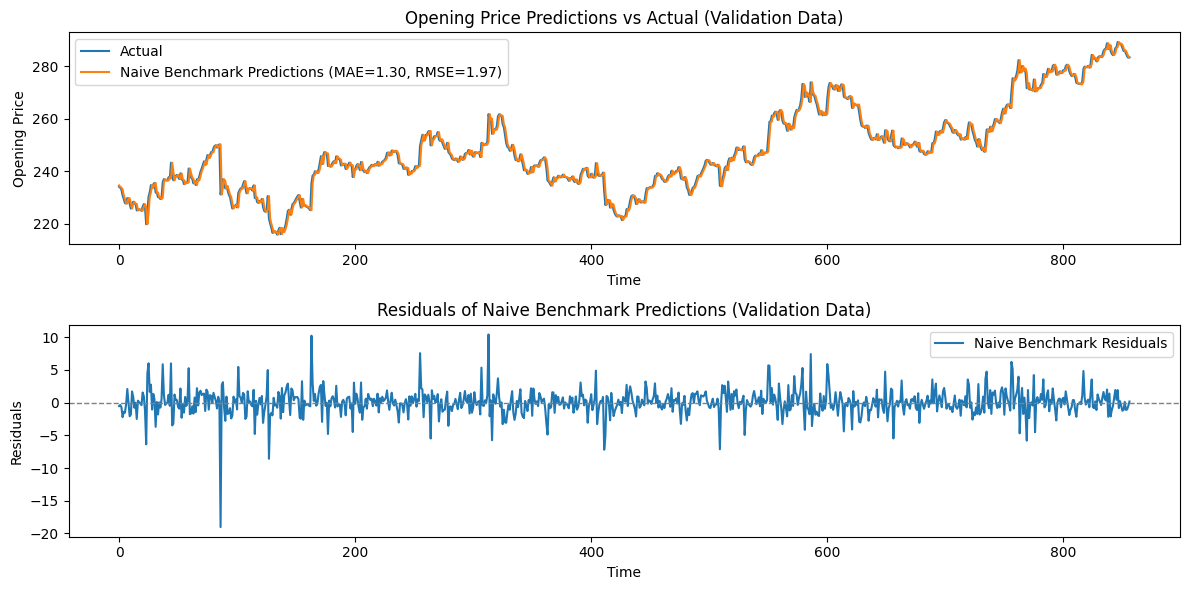

In [21]:
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(actual_vals, label='Actual')
plt.plot(naive_val_predictions, label=f'Naive Benchmark Predictions (MAE={mae_naive_val:.2f}, RMSE={rmse_naive_val:.2f})')
plt.title('Opening Price Predictions vs Actual (Validation Data)')
plt.xlabel('Time')
plt.ylabel('Opening Price')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(residuals_naive_val, label='Naive Benchmark Residuals')
plt.axhline(0, color='gray', linestyle='dashed', linewidth=1)
plt.title('Residuals of Naive Benchmark Predictions (Validation Data)')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()
plt.tight_layout()
plt.show()

Let's now compare the models to this benchmark:

In [22]:
# Print statistics for the Naive Benchmark on validation and test data
print("\nNaive Benchmark Statistics (Validation Data):")
print(f"MAE: {mae_naive_val:.2f}, MSE: {mse_naive_val:.2f}, RMSE: {rmse_naive_val:.2f}")

print("\nNaive Benchmark Statistics (Test Data):")
print(f"MAE: {mae_naive_test:.2f}, MSE: {mse_naive_test:.2f}, RMSE: {rmse_naive_test:.2f}")

# Compare the models based on their validation and test performance
print("\nComparison of Models (Validation Data):")
print(f"Model 1: MAE={mae_model1_val:.2f}, RMSE={rmse_model1_val:.2f}")
print(f"Model 2: MAE={mae_model2_val:.2f}, RMSE={rmse_model2_val:.2f}")
print(f"Naive Benchmark: MAE={mae_naive_val:.2f}, RMSE={rmse_naive_val:.2f}")

print("\nComparison of Models (Test Data):")
print(f"Model 1: MAE={mae_model1_test:.2f}, RMSE={rmse_model1_test:.2f}")
print(f"Model 2: MAE={mae_model2_test:.2f}, RMSE={rmse_model2_test:.2f}")
print(f"Naive Benchmark: MAE={mae_naive_test:.2f}, RMSE={rmse_naive_test:.2f}")


Naive Benchmark Statistics (Validation Data):
MAE: 1.30, MSE: 3.87, RMSE: 1.97

Naive Benchmark Statistics (Test Data):
MAE: 1.29, MSE: 4.52, RMSE: 2.13

Comparison of Models (Validation Data):
Model 1: MAE=1.40, RMSE=2.07
Model 2: MAE=1.60, RMSE=2.28
Naive Benchmark: MAE=1.30, RMSE=1.97

Comparison of Models (Test Data):
Model 1: MAE=2.79, RMSE=3.52
Model 2: MAE=3.17, RMSE=3.90
Naive Benchmark: MAE=1.29, RMSE=2.13


Not too bad for a first attempt.

# Next steps/ wishlist

When I get some time these will be the next steps:
1. Hyperparameter tuning: Experimenting with different hyperparameters e.g the number of LSTM units, learning rate, batch size, and dropout rate. Maybe using techniques like grid search or random search to find the optimal set of hyperparameters, or dploying one of those automatic tuners.
2. Model architecture: Exploring different model architectures and variations of LSTMs. We can try using bidirectional LSTMs, stacked LSTMs, different activation functions in the dense layers. Maybe even other RNN architectures like GRUs.
3. Feature engineering: We dropped a lot of features from the dataset: volumes, highs, lows etc. Can these improve our model's accuracy?
4. Ensembling: Just found out about ensembling techniques: averaging predictions from multiple LSTM models or even combining RNN predictions with predictions from other types of models (e.g., classical time series models).
5. Cross-validation: Instead of a train-test-split, a k-fold cross validation should yield better assessments.
6. Longer forecasting horizons: We'll extend the forecasting to predict multiple time steps into the future, rather than just the next data point.
7. Model interpretability: We could implement feature importance analysis, to understand how the model makes its decisions. TRy to explain the predictions: look into LIME and SHAP.
8. Normalization: We'll look into how the big boys and girls do normalization and outlier detection.
9. More assets. Why should Microsost have all the fun?
10. Overfitting Analysis: L2-regularization, stopping early?
11. Live forecasting: why predict the past when I can predict the future?